# DL training

## Setup

In [1]:
import numpy as np, pandas as pd
import os, random
from katlas.data import *
from katlas.train import *
from fastai.vision.all import *
from katlas.dnn import *

In [2]:
seed_everything()

In [3]:
def_device

'cuda'

## Data

In [4]:
df=pd.read_parquet('train/cddm_t5.parquet')

In [5]:
info=Data.get_kinase_info()

info = info[info.pseudo=='0']

info = info[info.kd_ID.notna()]

subfamily_map = info[['kd_ID','subfamily']].drop_duplicates().set_index('kd_ID')['subfamily']
family_map = info[['kd_ID','family']].drop_duplicates().set_index('kd_ID')['family']
group_map = info[['kd_ID','group']].drop_duplicates().set_index('kd_ID')['group']

kinase_info = pd.DataFrame(df.index.tolist(),columns=['kinase'])

kinase_info['subfamily'] = kinase_info.kinase.map(subfamily_map)
kinase_info['family'] = kinase_info.kinase.map(family_map)
kinase_info['group'] = kinase_info.kinase.map(group_map)

In [6]:
df=df.reset_index()

In [7]:
df.columns

Index(['index', '-20P', '-19P', '-18P', '-17P', '-16P', '-15P', '-14P', '-13P',
       '-12P',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1968)

In [8]:
# column name of feature and target
feat_col = df.columns[df.columns.str.startswith('T5_')]
target_col = df.columns[~df.columns.isin(feat_col)][1:]

In [9]:
feat_col

Index(['T5_0', 'T5_1', 'T5_2', 'T5_3', 'T5_4', 'T5_5', 'T5_6', 'T5_7', 'T5_8',
       'T5_9',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1024)

## Split

In [10]:
kinase_info.subfamily.value_counts()

subfamily
Eph     12
Src     11
STE7     7
NEK      7
CK1      6
        ..
PDK1     1
GCN2     1
CDC7     1
MAST     1
RAF      1
Name: count, Length: 136, dtype: int64

In [11]:
kinase_info.family.value_counts()

family
STE20    22
CAMKL    17
Eph      12
MAPK     12
Src      11
         ..
STK33     1
PDK1      1
CDC7      1
MAST      1
RAF       1
Name: count, Length: 88, dtype: int64

In [12]:
kinase_info.group.value_counts()

group
TK          80
CAMK        47
AGC         45
Other       40
CMGC        39
STE         35
TKL         21
CK1          9
Atypical     4
Name: count, dtype: int64

In [13]:
splits = get_splits(kinase_info, group='subfamily',nfold=5)

split0 = splits[0]

GroupKFold(n_splits=5, random_state=None, shuffle=False)
# subfamily in train set: 110
# subfamily in test set: 26


## Dataset

In [14]:
# dataset
ds = GeneralDataset(df,feat_col,target_col)

In [15]:
len(ds)

320

In [16]:
dl = DataLoader(ds, batch_size=64, shuffle=True)

In [17]:
xb,yb = next(iter(dl))

xb.shape,yb.shape

(torch.Size([64, 1024]), torch.Size([64, 23, 41]))

## Model

In [18]:
n_feature = len(feat_col)
n_target = len(target_col)

In [19]:

# def get_mlp(): return PSSM_model(n_feature,n_target,model='MLP')

def get_cnn(): return PSSM_model(n_feature,n_target,model='CNN')

In [20]:
model = get_cnn()

In [21]:
logits= model(xb)

In [22]:
logits.shape

torch.Size([64, 23, 41])

## Loss

In [23]:
CE(logits,yb)

tensor(3.3115, grad_fn=<MeanBackward0>)

## Metrics

In [24]:
KLD(logits,yb)

tensor(0.5317, grad_fn=<MeanBackward0>)

In [25]:
JSD(logits,yb)

tensor(0.1252, grad_fn=<MeanBackward0>)

## CV train
> cross-validation

In [26]:
oof = train_dl_cv(df,feat_col,target_col,
                  splits = splits,
                  model_func = get_cnn,
                  n_epoch=20,lr=3e-3,save='cnn_cddm')

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.282649,3.128296,0.319262,0.081570,00:01
1,3.241650,3.113522,0.304488,0.079595,00:00
2,3.212050,3.113102,0.304069,0.077892,00:00
3,3.195983,3.120565,0.311531,0.078662,00:00
4,3.178256,2.976437,0.167403,0.044890,00:00
5,3.148183,2.948758,0.139725,0.036188,00:00
6,3.109516,2.925130,0.116096,0.029711,00:00
7,3.072004,2.909240,0.100206,0.026152,00:00
8,3.039572,2.904013,0.094980,0.025093,00:00
9,3.012379,2.898960,0.089926,0.023662,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.282195,3.130908,0.322224,0.081733,00:00
1,3.243584,3.113548,0.304865,0.078650,00:00
2,3.219855,3.120547,0.311864,0.079403,00:00
3,3.209427,3.087194,0.278511,0.069197,00:00
4,3.201059,2.992566,0.183883,0.048371,00:00
5,3.167005,2.937138,0.128454,0.033072,00:00
6,3.121017,2.924041,0.115357,0.029413,00:00
7,3.082160,2.915458,0.106775,0.027174,00:00
8,3.049422,2.906384,0.097700,0.025222,00:00
9,3.022278,2.902709,0.094025,0.024238,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.282472,3.127070,0.353896,0.091299,00:00
1,3.241385,3.109268,0.336093,0.088014,00:00
2,3.209924,3.114542,0.341367,0.087262,00:00
3,3.193899,3.053725,0.280551,0.073127,00:00
4,3.181828,2.961300,0.188125,0.050201,00:00
5,3.145959,2.931028,0.157853,0.041150,00:00
6,3.109088,2.925400,0.152225,0.038905,00:00
7,3.075637,2.922864,0.149690,0.038691,00:00
8,3.047635,2.909077,0.135902,0.035387,00:00
9,3.024517,2.901939,0.128764,0.033550,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.280588,3.129339,0.335539,0.085304,00:00
1,3.240295,3.119176,0.325376,0.083852,00:00
2,3.210839,3.091391,0.297591,0.077241,00:00
3,3.200143,3.042270,0.248470,0.065589,00:00
4,3.195208,3.029967,0.236167,0.060239,00:00
5,3.157714,2.951658,0.157859,0.039547,00:00
6,3.114407,2.937240,0.143440,0.036184,00:00
7,3.076996,2.915984,0.122185,0.031200,00:00
8,3.044734,2.903373,0.109573,0.028193,00:00
9,3.018122,2.900592,0.106792,0.027362,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.283504,3.130594,0.363589,0.093193,00:00
1,3.243992,3.116076,0.349071,0.090924,00:00
2,3.210798,3.120450,0.353445,0.090563,00:00
3,3.199268,3.072872,0.305868,0.079987,00:00
4,3.177695,2.966492,0.199487,0.053601,00:00
5,3.137152,2.917118,0.150113,0.039282,-1:59:59
6,3.099840,2.911311,0.144307,0.037135,00:00
7,3.071257,2.897541,0.130536,0.034004,00:00
8,3.047829,2.894860,0.127856,0.033557,00:00
9,3.024281,2.900576,0.133571,0.034486,00:00


In [27]:
oof.to_parquet('raw/oof_cddm.parquet')

## Score

In [31]:
from katlas.pssm import *

from functools import partial

In [32]:
def score_df(target,pred,func):
    distance = [func(target.loc[i],pred.loc[i,target.columns]) for i in target.index]
    return pd.Series(distance,index=target.index)

In [44]:
jsd_df = partial(score_df,func=js_divergence_flat)
kld_df = partial(score_df,func=kl_divergence_flat)

In [45]:
target=df[target_col].copy()

In [46]:
kinase_info['group_split'] = oof.nfold

In [47]:
kinase_info['group_jsd'] =jsd_df(target,oof)

In [48]:
from katlas.plot import *

In [49]:
set_sns()

Text(0.5, 1.0, 'GroupSplit by subfamily (nfold=5) in kinase subfamily')

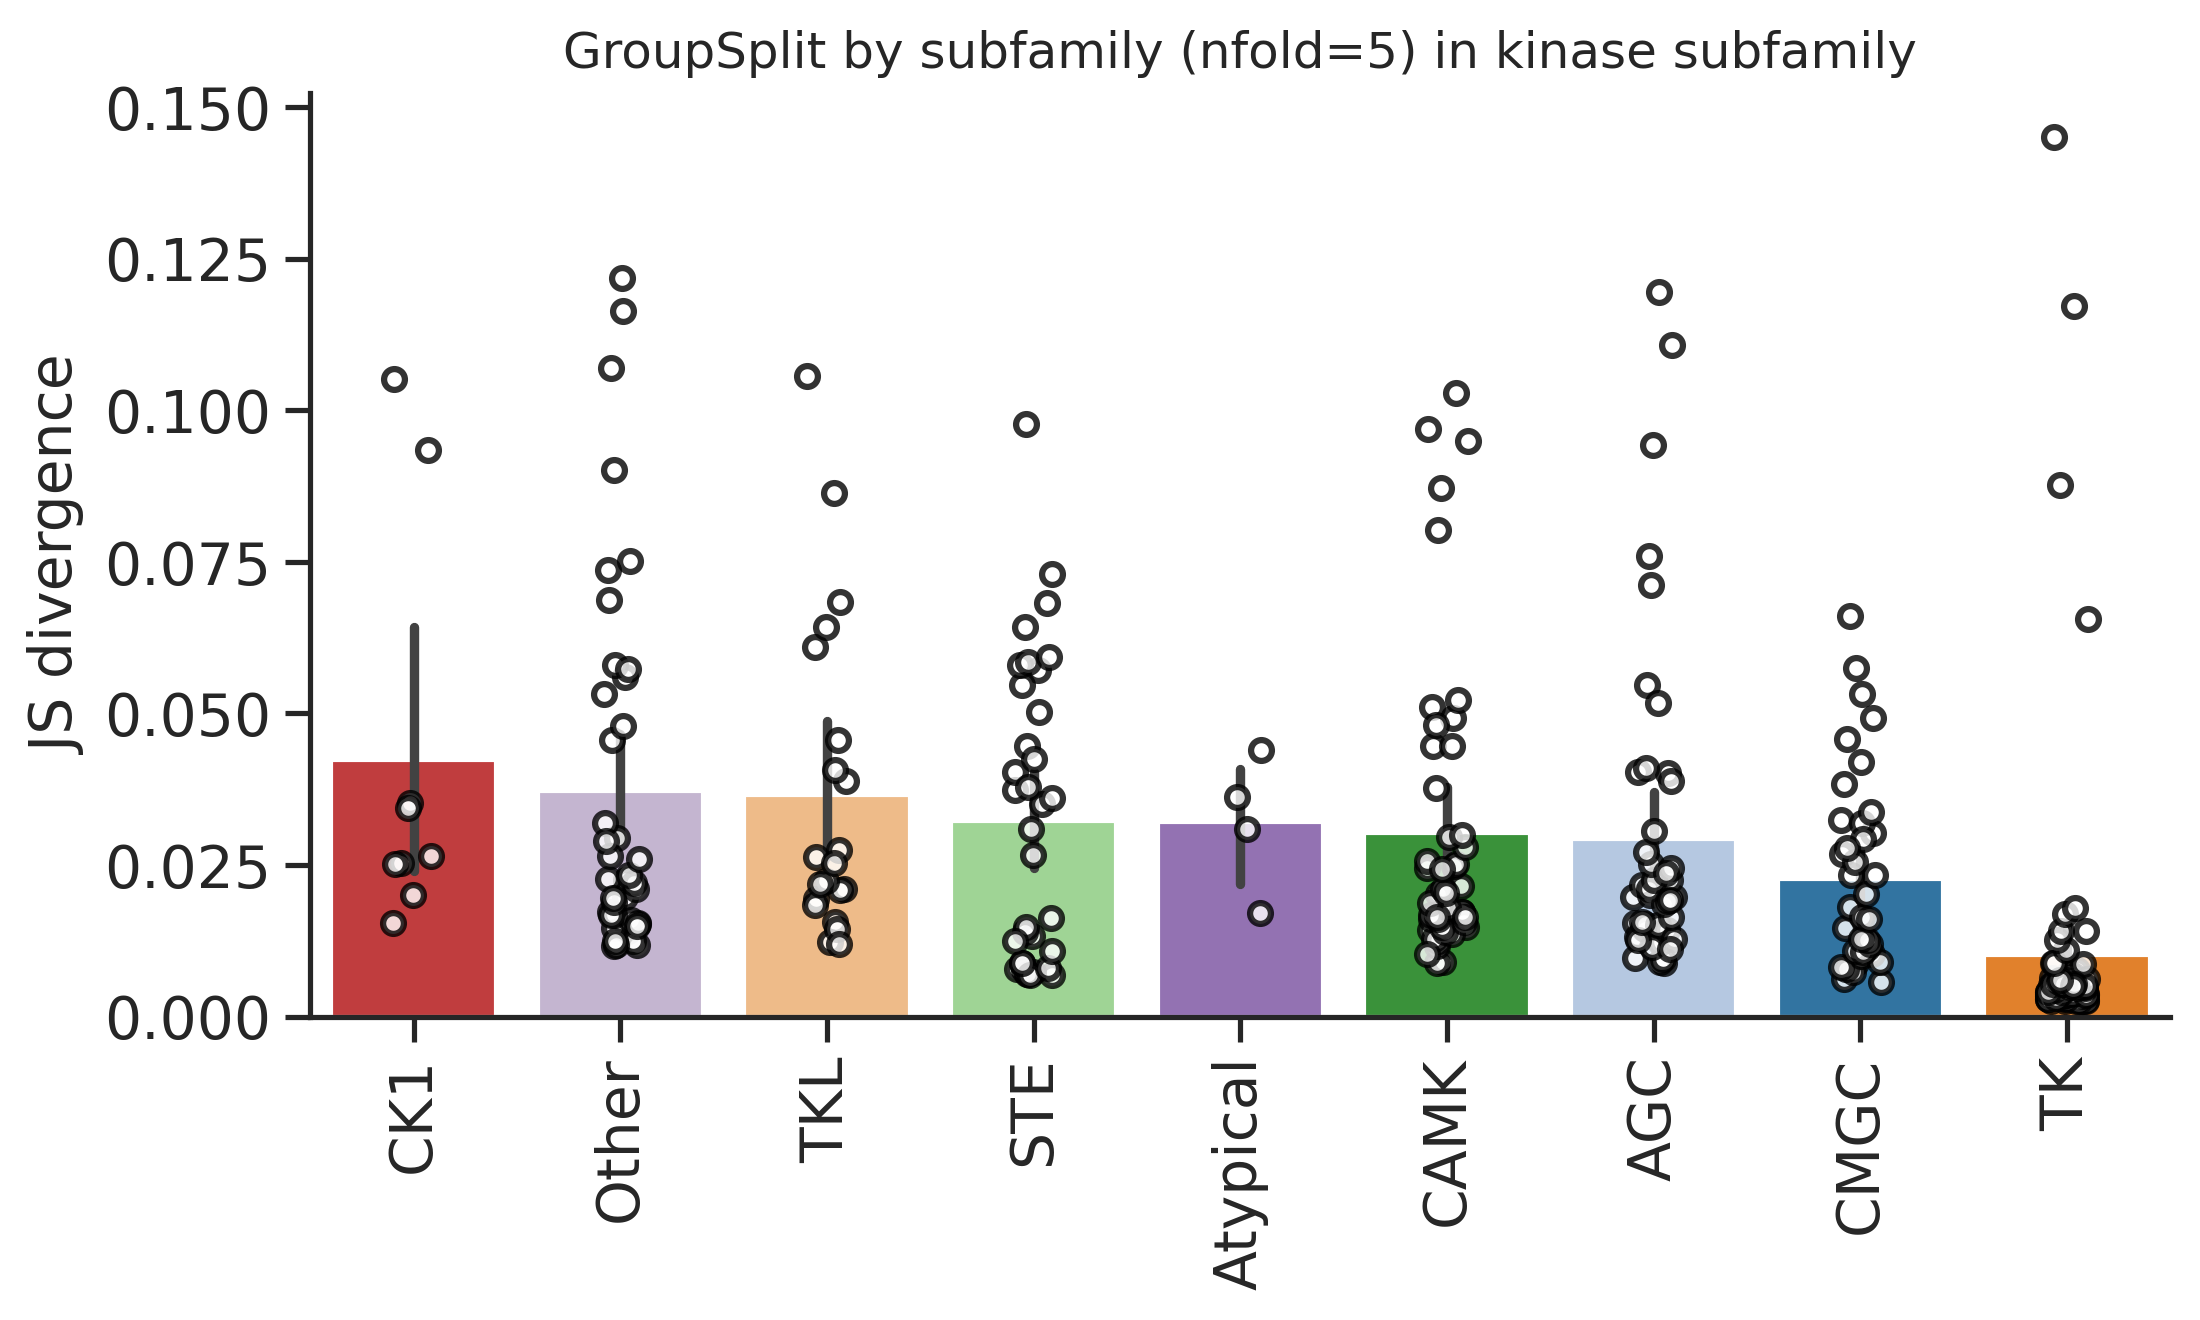

In [50]:
plot_bar(kinase_info,'group_jsd',group='group',palette=group_color,figsize=(8,4))
plt.ylabel('JS divergence')
plt.title('GroupSplit by subfamily (nfold=5) in kinase subfamily')

In [51]:
group_color = pd.DataFrame(group_color).T

In [52]:
sty_color

{'S': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'T': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'Y': (1.0, 0.4980392156862745, 0.054901960784313725)}

In [53]:
group_color = group_color.reset_index(names='modi_group')

In [54]:
info = Data.get_kinase_info()

In [55]:
subfamily_color = info[['modi_group','subfamily']].merge(group_color).drop(columns=['modi_group']).set_index('subfamily')

In [56]:
subfamily_color = subfamily_color.apply(tuple, axis=1).to_dict()

Text(0, 0.5, 'JS divergence')

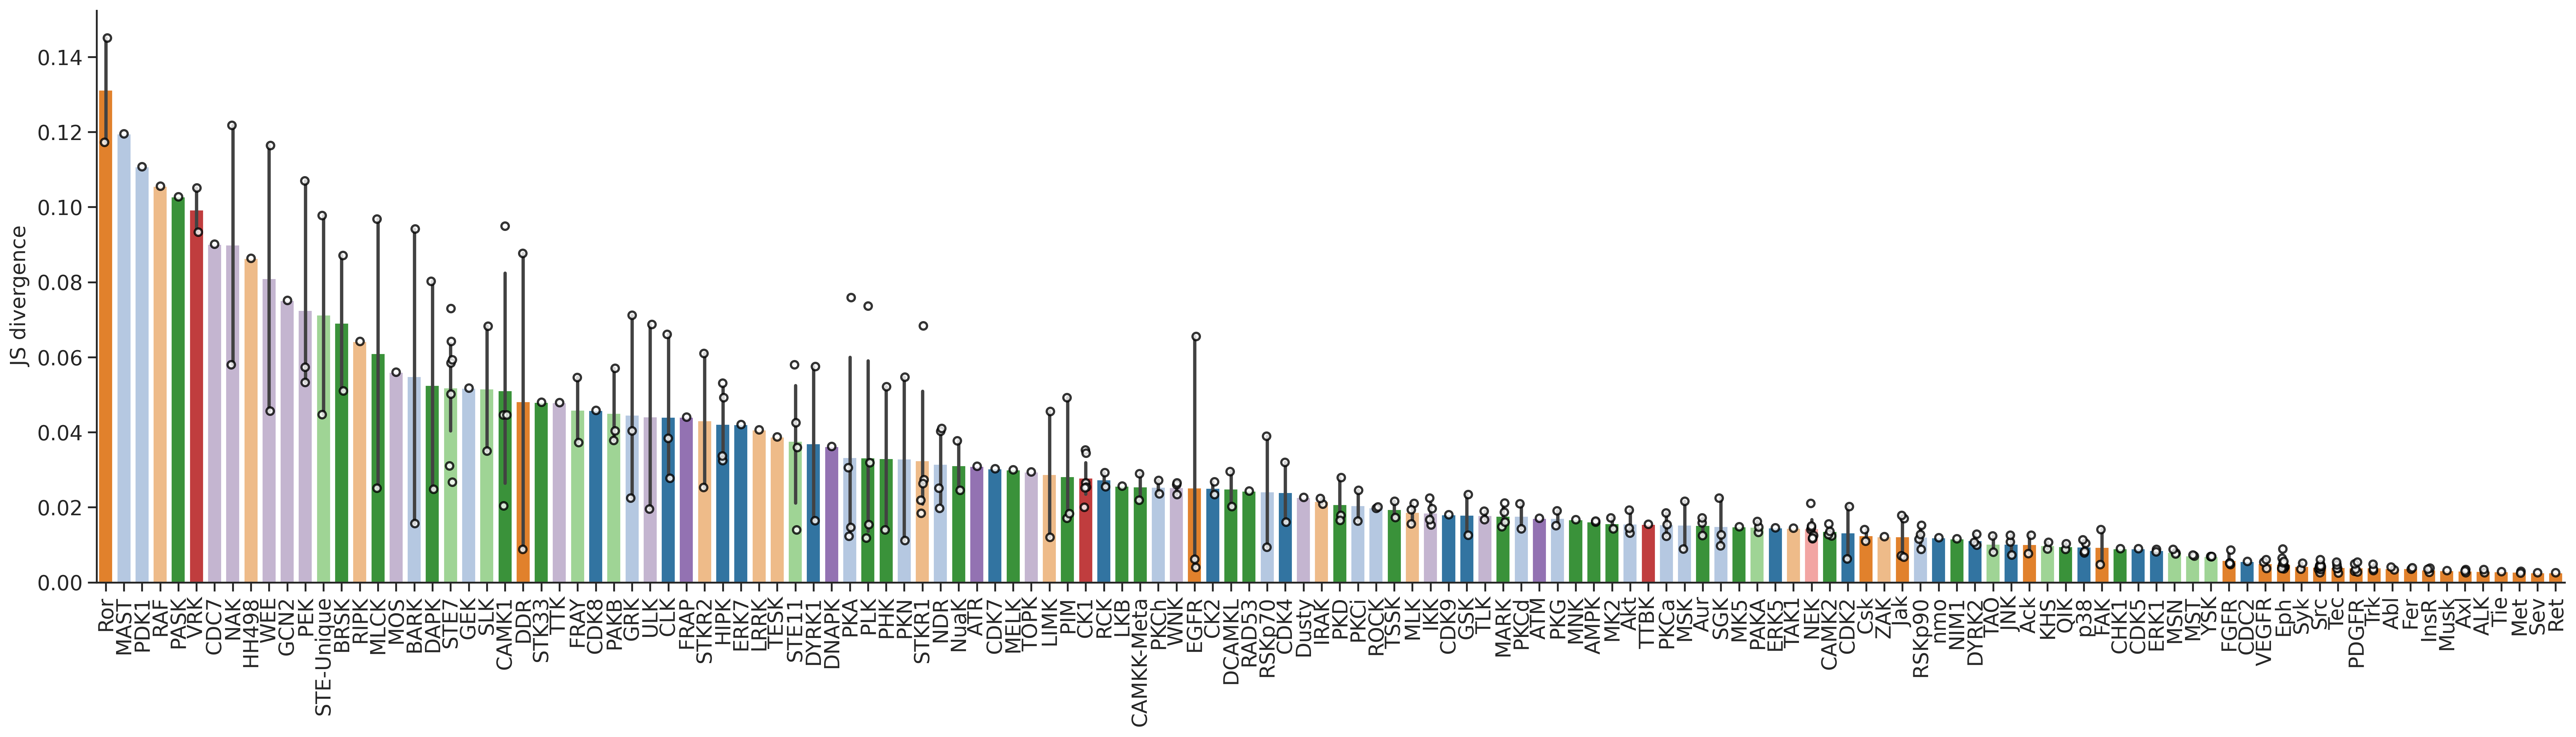

In [57]:
plot_bar(kinase_info,'group_jsd',group='subfamily',palette = subfamily_color, figsize=(30,7))
plt.ylabel('JS divergence')
# plt.title('Stratified split in kinase subfamily')

In [ ]:
from katlas.pssm import *

In [58]:
def plot_one_pssm(target,pred,idx):
    target_pssm = recover_pssm(target.loc[idx])
    pred_pssm = recover_pssm(pred.loc[idx,target.columns])
    plot_heatmap(target_pssm,figsize=(10,6))
    plot_heatmap(pred_pssm,figsize=(10,6))

In [59]:
set_sns(100)

In [63]:
kinase_info[kinase_info.kinase.str.contains('CDK')]

,kinase,subfamily,family,group,group_split,group_jsd
34,P06493_CDK1_HUMAN_KD1,CDC2,CDK,CMGC,1,0.005642
39,P24941_CDK2_HUMAN_KD1,CDK2,CDK,CMGC,0,0.006260
102,Q00535_CDK5_HUMAN_KD1,CDK5,CDK,CMGC,3,0.008968
168,P50750_CDK9_HUMAN_KD1,CDK9,CDK,CMGC,4,0.018047
204,Q00534_CDK6_HUMAN_KD1,CDK4,CDK,CMGC,1,0.016037
224,P50613_CDK7_HUMAN_KD1,CDK7,CDK,CMGC,2,0.030289
228,Q00526_CDK3_HUMAN_KD1,CDK2,CDK,CMGC,0,0.020181
240,P11802_CDK4_HUMAN_KD1,CDK4,CDK,CMGC,1,0.031994
280,P49336_CDK8_HUMAN_KD1,CDK8,CDK,CMGC,0,0.045855


CDK7:

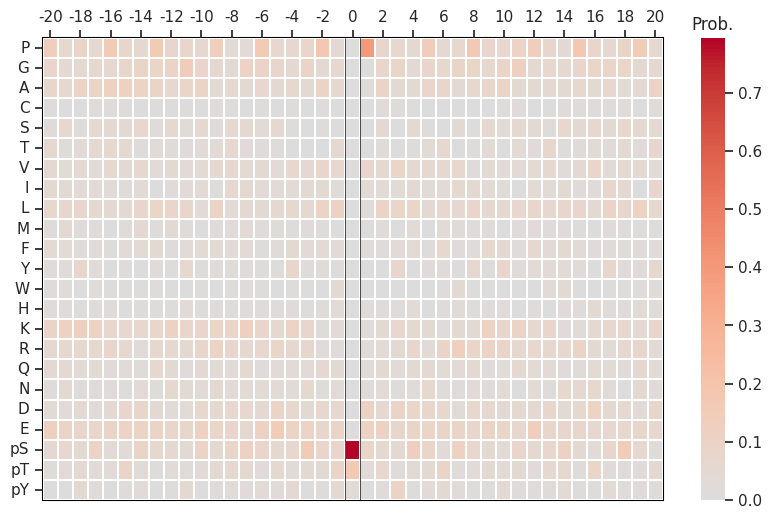

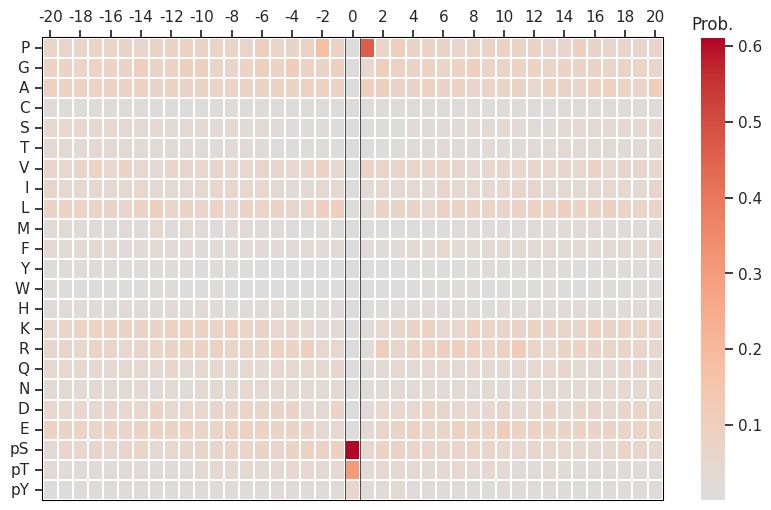

In [66]:
plot_one_pssm(target,oof,224)

Compare with pspa CDK:

In [67]:
df2=pd.read_parquet('train/pspa_t5.parquet')

In [68]:
series= df2[df2.index.str.contains('CDK7')].iloc[0]

<Axes: >

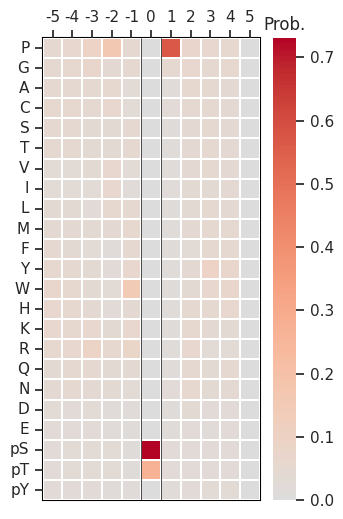

In [70]:
plot_heatmap(recover_pssm(series),figsize=(3.5,6))